In [77]:
# sentdex's example on the use of linear regression in predicting stock prices 

import quandl, math, datetime, pickle
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

df = quandl.get('WIKI/GOOGL')
df = df[['Adj. Open', 'Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_Change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0
df = df[['Adj. Close', 'HL_PCT','PCT_Change','Adj. Volume']]

In [78]:
df.head()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0


In [79]:
forecast_col = 'Adj. Close'
df.fillna(-99999, inplace=True)
forecast_out = int(math.ceil(0.01 * len(df)))
# forecast_out is just a percentage of our data to forecast out. Basically, in our dataset, 
# maybe we want to train our model to predict the price 1% into the future. Then, to train, 
# we need historically to grab values, and then use those values alongside whatever the price 
# was 1% into the future (1% into the future as in 1% of the days of the entire dataset. If the 
# dataset was 100 days, 1% into the future would be 1 day into the future). We use .shift, which 
# is a pandas method, which can take a column and literally shift it in a direction by a number 
# you decide. Thus, we use this to make a new column, which is the price column shifted, giving us 
# the future prices in the same rows as current price, volume etc to be trained against.
df['label'] = df[forecast_col].shift(-forecast_out)
df.head()

,Adj. Close,HL_PCT,PCT_Change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,69.399229
2004-08-20,54.322689,7.921706,7.227007,22834300.0,68.752232
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,69.639972
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,69.078238
2004-08-25,53.164113,3.886792,1.183658,9188600.0,67.839414


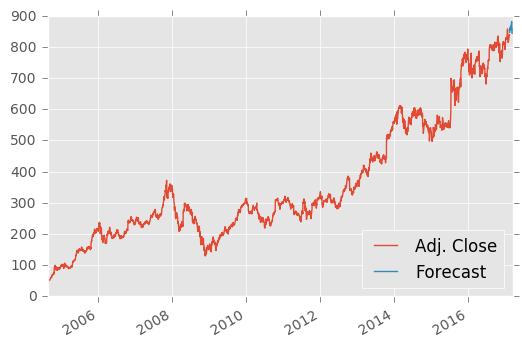

In [80]:
# list of features
X = np.array(df.drop(['label'],1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out:]
# In pandas, when the data in a column/row is not available, it's labelled NaN(not a number). dropna() removes 
# these "cells" and "inplace=True" means change it in the dataset and not just the copy of the dataset.
df.dropna(inplace=True)

y = np.array(df['label'])

# 0.2 in test_size means we want the test size to be 20 percent of the whole data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# n_jobs specifies the number of jobs
clf = LinearRegression(n_jobs=10)
# changes easily to SVM
# clf = svm.SVR(kernel='poly')
clf.fit(X_train, y_train)

# with open('linearregression.pickle', 'wb') as f:
#     pickle.dump(clf, f)
# pickle_in = open('linearregression.pickle', 'rb') 
# clf = pickle.load(pickle_in)
    
accuracy = clf.score(X_test, y_test)

forecast_set = clf.predict(X_lately)

# print(forecast_set, accuracy, forecast_out)
df['Forecast'] = np.nan
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns) - 1)] + [i]
    
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel = 'Date'
plt.ylabel = 'Price'
plt.show()
